In [1]:
!pip install einops keras_nlp

  Using cached einops-0.6.1-py3-none-any.whl (42 kB)
  Using cached keras_nlp-0.6.0-py3-none-any.whl (576 kB)
  Using cached rich-13.4.2-py3-none-any.whl (239 kB)
  Using cached tensorflow_text-2.10.0-cp38-cp38-win_amd64.whl (5.0 MB)
  Using cached keras_core-0.1.0-py3-none-any.whl (727 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached Pygments-2.15.1-py3-none-any.whl (1.1 MB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Repoo\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Repoo\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\Repoo\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\Repoo\anaconda3\lib\http\client.py", line 458, in read
    n = self.readinto(b)
  File "C:\Users\Repoo\anaconda3\lib\http\client.py", line 502, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Repoo\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\Repoo\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\Repoo\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
soc

In [3]:
!pip install einops

  Using cached einops-0.6.1-py3-none-any.whl (42 kB)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import einops

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Create the dataset

#### read the captions txt file and make dict that has image name as its key image captions as a list

In [6]:
from collections import defaultdict
import re
import string

def clean(x):
    x = re.sub(r'{ .\n|\n|}', '', x)
    x = x.lower()
    x = re.sub(f'[{re.escape(string.punctuation)}]', '', x)
    
    return x.strip()

imgs = []
caps = []

caption_path = '/kaggle/input/flickr8k/captions.txt'
image_path = '/kaggle/input/flickr8k/Images/'
with open(caption_path, 'r') as f:
    next(f)
    lines = f.readlines()

for line in lines:
    arr = line.split(',')
    imgs.append(image_path + arr[0])
    caps.append(clean(arr[1]))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/flickr8k/captions.txt'

### decoding text

we will use TextVectorizer layer and create word_to_idx and idx_to_word using
StringLookup layer

In [4]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import StringLookup

max_length = max(len(x.split()) for x in caps)

def standardize_input(x):
    x = tf.strings.join(['[START]', x], separator=' ')
    
    return x

def standardize_output(x):
    x = tf.strings.join([x, '[END]'], separator=' ')
    
    return x

input_txt_vect = TextVectorization(
                output_sequence_length=max_length,
                standardize=standardize_input
            )

output_txt_vect = TextVectorization(
                output_sequence_length=max_length,
                standardize=standardize_output
            )

input_txt_vect.adapt(caps)
output_txt_vect.adapt(caps)

vocab = input_txt_vect.get_vocabulary()
print(len(input_txt_vect.get_vocabulary()))
vocab[:10]

8633


['', '[UNK]', 'a', '[START]', 'in', 'the', 'on', 'is', 'and', 'dog']

### handling images

In [5]:
IMAGE_SHAPE=(299, 299, 3)

#read image and resize it
def read_and_resize(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    
    return img

### split data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
def make_dataset(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    def tokenize(x, y):

        return ({'encoder_inputs': read_and_resize(x), 'decoder_inputs': input_txt_vect(y)}, output_txt_vect(y))

    dataset = dataset.map(tokenize)
    return dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE)
    
x_train, x_test, y_train, y_test = train_test_split(imgs, caps, test_size=.1, random_state=42)

In [9]:
train_ds = make_dataset(x_train, y_train)
test_ds = make_dataset(x_test, y_test)

for (x, z) in train_ds.take(1):
    print(x, z)

{'encoder_inputs': <tf.Tensor: shape=(32, 299, 299, 3), dtype=float32, numpy=
array([[[[9.13444824e+01, 1.45311035e+02, 1.07983276e+02],
         [8.99498291e+01, 1.40000000e+02, 1.03000000e+02],
         [8.67224121e+01, 1.42722412e+02, 1.05722412e+02],
         ...,
         [8.35554199e+01, 1.14444580e+02, 8.87640076e+01],
         [7.80916443e+01, 1.10983337e+02, 8.40000000e+01],
         [8.16969910e+01, 1.11663910e+02, 8.73360901e+01]],

        [[9.11137772e+01, 1.44668121e+02, 1.05604065e+02],
         [9.44775543e+01, 1.38730576e+02, 1.04939667e+02],
         [8.63047333e+01, 1.44211609e+02, 1.04178543e+02],
         ...,
         [7.72803650e+01, 1.18131523e+02, 9.23512039e+01],
         [8.32080154e+01, 1.11669868e+02, 8.33407059e+01],
         [8.36314926e+01, 1.14724205e+02, 8.55942993e+01]],

        [[9.29683533e+01, 1.44466431e+02, 1.08418900e+02],
         [9.23197784e+01, 1.39747299e+02, 1.04757462e+02],
         [8.86687622e+01, 1.46557175e+02, 1.07268654e+02],
     

In [10]:
#constants

vocab_size = len(vocab)
seq_len    = max_length
emb_size  = 256
num_heads = 12
key_dims = 256
units = 256
dropout_rate = .3

## Create the model

The model architecture used here is inspired by Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
The archeticture uses an CNN image encoder and transformer decoder

### Image Encoder

i will use inception net here as an image feature extractor

In [11]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model

image_model = MobileNetV3Large(include_top=False, include_preprocessing=True)
image_model.trainable = False

class ImageFeatureExtractor(Model):
    def __init__(self, image_model):
        super(ImageFeatureExtractor, self).__init__()
        
        self.model = image_model
        
    def call(self, x):
        
        return self.model(x)
    
test_img = read_and_resize(imgs[0])[None, :]
ImageFeatureExtractor(image_model)(test_img)

12683000/12683000 [==============================] - 0s 0us/step


<tf.Tensor: shape=(1, 9, 9, 960), dtype=float32, numpy=
array([[[[-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.16213705, ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         ...,
         [-0.        ,  4.8903866 , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ]],

        [[-0.        , -0.        , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  4.8469644 , -0.        , ..., -0.        ,
          -0.        , -0.        ],
         [-0.        ,  1.2914808 , -0.        , ..., -0.16612087,
          -0.        , -0.   

Decoder Model is a trasformer decoder block

## Decoder Model

#### lets make an rnn decoder

In [16]:
units = 256
num_heads = 6
key_dims = 256
emb_size = 256

In [17]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import LSTM, Dense, MultiHeadAttention, Embedding, LayerNormalization, Dropout

class DecoderLSTM(Model):
    def __init__(self, units, num_heads, key_dims, vocab_size, emb_size, dropout_rate):
        super().__init__()
        
        self.embd  = Embedding(vocab_size, emb_size, mask_zero=True)
        self.lstm = LSTM(units, return_sequences=True)
        self.drp1 = Dropout(dropout_rate)
        
        self.attn = MultiHeadAttention(num_heads, key_dims)
        self.nrm1 = LayerNormalization()
        self.dense = Dense(units, activation='relu')
        self.drp2 = Dropout(dropout_rate)
        
        self.outputs = Dense(vocab_size, activation='softmax')
        
    def call(self, x, encoder_output):
        
        x = self.embd(x)
        x = self.drp1(x)
        x = self.lstm(x)
        
        attn, attn_scores = self.attn(x, encoder_output, return_attention_scores=True)
        self.last_attention_scores = attn_scores
        
        x = x + self.nrm1(attn)
        x = self.dense(x)
        x = self.drp2(x)
        
        return self.outputs(x)

In [18]:
class CaptionMeLSTM(Model):
    def __init__(self, image_model, num_heads, key_dims, units, vocab_size, emb_size, dropout_rate=.1):
        super(CaptionMeLSTM, self).__init__()
        
        self.encoder_model = ImageFeatureExtractor(image_model)
        self.decoder_model = DecoderLSTM(units, num_heads, key_dims, vocab_size, emb_size, dropout_rate)
#         Dense(256, activatio='relu')
    def call(self, inputs):
        x, y = inputs['encoder_inputs'], inputs['decoder_inputs']
        
        enc_out = self.encoder_model(x)
        enc_out = einops.rearrange(enc_out, 'b h w c -> b (h w) c')
        
        dec_out = self.decoder_model(y, enc_out)
        
        return dec_out

In [19]:
caption_lstm = CaptionMeLSTM(image_model, num_heads, key_dims, units, vocab_size, emb_size, dropout_rate=.3)
# caption_lstm(next(iter(dataset)))

In [20]:
caption_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = caption_lstm.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15)

Epoch 1/15
1138/1138 [==============================] - 263s 218ms/step - loss: 1.4934 - accuracy: 0.7503 - val_loss: 1.2511 - val_accuracy: 0.7698
Epoch 2/15
1138/1138 [==============================] - 209s 184ms/step - loss: 1.1847 - accuracy: 0.7753 - val_loss: 1.1303 - val_accuracy: 0.7817
Epoch 3/15
1138/1138 [==============================] - 209s 184ms/step - loss: 1.0835 - accuracy: 0.7839 - val_loss: 1.0781 - val_accuracy: 0.7892
Epoch 4/15
1138/1138 [==============================] - 212s 186ms/step - loss: 1.0177 - accuracy: 0.7894 - val_loss: 1.0513 - val_accuracy: 0.7919
Epoch 5/15
1138/1138 [==============================] - 205s 180ms/step - loss: 0.9680 - accuracy: 0.7937 - val_loss: 1.0315 - val_accuracy: 0.7955
Epoch 6/15
1138/1138 [==============================] - 206s 181ms/step - loss: 0.9260 - accuracy: 0.7968 - val_loss: 1.0282 - val_accuracy: 0.7973
Epoch 7/15
1138/1138 [==============================] - 206s 181ms/step - loss: 0.8917 - accuracy: 0.8001 - val_

In [ ]:
caption_lstm.save('/kaggle/working/')
caption_lstm.save_weights('/kaggle/working/')

In [95]:
import pickle

with open('/kaggle/working/vocab.pkl', 'wb') as f:
    pickle.dump((idx_to_wrd, wrd_to_idx), f)

# Inference

In [ ]:
from tensorflow.keras.models import load_model

caption_me = tf.saved_model.load('/kaggle/working/')

In [96]:
with open('/kaggle/working/vocab.pkl', 'rb') as f:
    idx_to_wrd, wrd_to_idx = pickle.load(f)

In [97]:
import matplotlib.pyplot as plt
import cv2
import random

def inference(idx, i):
    src = imgs[idx]
    image = cv2.imread(src)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,i)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    def caption(src):
        test_img = read_and_resize(src)[None, :]

        tokens = []
        start = '[START]'

        vect = wrd_to_idx[start]
        inputs = np.reshape(vect, (1, 1))
        for i in range(33):
            outputs = caption_lstm({"encoder_inputs":test_img, "decoder_inputs": inputs}).numpy()
            preds = outputs[:, -1, :]
            idx = tf.argmax(preds, axis=-1)[:, None]
            wrd = idx_to_wrd[idx.numpy()[0][0]]
            if wrd == '[END]' or wrd == '[START]':
                break
            print(wrd, end=" ")
            tokens.append(wrd)
            inputs = tf.concat([inputs, idx], axis=1)

        return ' '.join(tokens)

    return caption(src)

### picking random imgs from the dataset

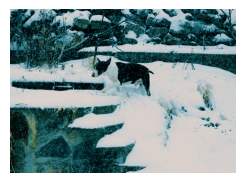

a black dog is standing in the snow 

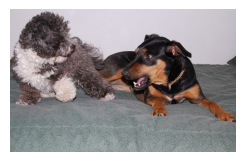

a black and black dog is playing with a black and white dog 

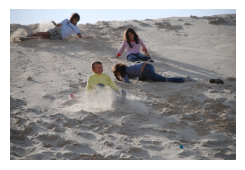

four people are walking on a beach 

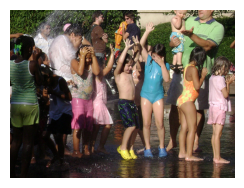

a group of children are in a sprinkler 

In [99]:
for i in range(1, 5):
    idx = random.randint(0, 8000)
    inference(idx, i);